In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import os
import shutil
import time
import math
import pandas as pd
from PIL import Image
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<h2>Reducing Dataset by 50% and keeping 20% for Unseen Testing</h2>

Dataset has been reduced and test set created.
Category 'call': Original Count = 6939, Test Count = 1388, Reduced Count = 2776
Category 'dislike': Original Count = 7028, Test Count = 1406, Reduced Count = 2811
Category 'fist': Original Count = 6882, Test Count = 1377, Reduced Count = 2753
Category 'four': Original Count = 7183, Test Count = 1437, Reduced Count = 2873
Category 'like': Original Count = 6823, Test Count = 1365, Reduced Count = 2729
Category 'mute': Original Count = 7139, Test Count = 1428, Reduced Count = 2856
Category 'ok': Original Count = 6924, Test Count = 1385, Reduced Count = 2770
Category 'one': Original Count = 7062, Test Count = 1413, Reduced Count = 2825
Category 'palm': Original Count = 7050, Test Count = 1410, Reduced Count = 2820
Category 'peace': Original Count = 6965, Test Count = 1393, Reduced Count = 2786
Category 'peace_inverted': Original Count = 6876, Test Count = 1376, Reduced Count = 2750
Category 'rock': Original Count = 6883, Test Count = 1377, Red

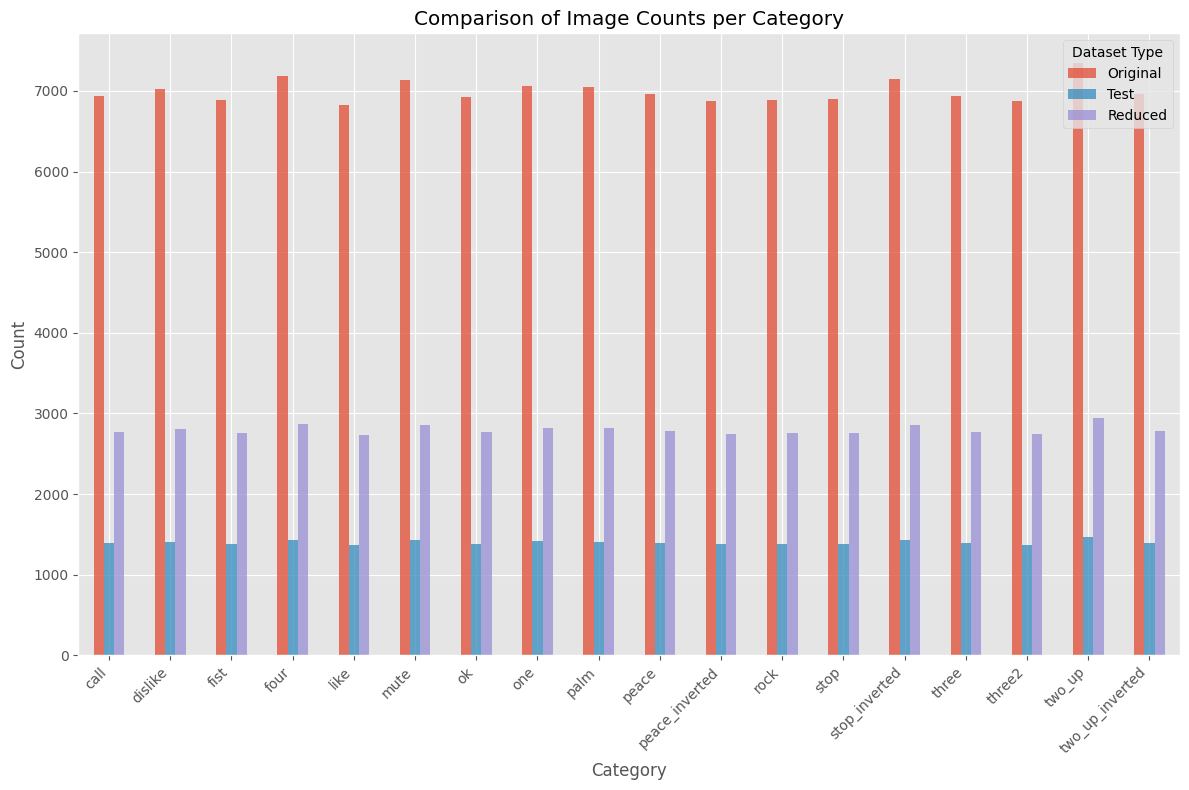

In [2]:
source_dir = 'hagridset'

destination_reduced_dir = 'hagridset_reduced'
destination_test_dir = 'hagridset_test'

# Ensure destination directories exist
if not os.path.exists(destination_reduced_dir):
    os.makedirs(destination_reduced_dir)
if not os.path.exists(destination_test_dir):
    os.makedirs(destination_test_dir)

# Dictionary to store image counts
image_count = {}

# Process each category directory
for category in os.listdir(source_dir):
    category_dir = os.path.join(source_dir, category)
    if os.path.isdir(category_dir):
        # Create the same category directories in the reduced and test dataset directories
        reduced_category_dir = os.path.join(destination_reduced_dir, category)
        test_category_dir = os.path.join(destination_test_dir, category)
        if not os.path.exists(reduced_category_dir):
            os.makedirs(reduced_category_dir)
        if not os.path.exists(test_category_dir):
            os.makedirs(test_category_dir)

        # Get all images in the category directory
        images = [os.path.join(category_dir, img) for img in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, img))]

        # Track original number of images
        original_count = len(images)

        # Split the data to retain 20% for testing
        remaining_images, test_images = train_test_split(images, test_size=0.20, random_state=389052)

        # Track number of test images
        test_count = len(test_images)

        # Split the remaining 80% of data, retaining only 50% of what's left
        _, reduced_images = train_test_split(remaining_images, test_size=0.50, random_state=389052)

        # Track reduced number of images
        reduced_count = len(reduced_images)

        # Update dictionary with counts
        image_count[category] = {'original': original_count, 'test': test_count, 'reduced': reduced_count}

        # Copy selected images to the new reduced directory
        for img in reduced_images:
            shutil.copy(img, reduced_category_dir)

        # Copy selected images to the new test directory
        for img in test_images:
            shutil.copy(img, test_category_dir)

# Output results
print("Dataset has been reduced and test set created.")
for category, counts in image_count.items():
    print(f"Category '{category}': Original Count = {counts['original']}, Test Count = {counts['test']}, Reduced Count = {counts['reduced']}")

data = pd.DataFrame(image_count).transpose()
data.reset_index(inplace=True)
data.columns = ['Category', 'Original', 'Test', 'Reduced']

plt.style.use('ggplot')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Plot data
data.plot(kind='bar', x='Category', y=['Original', 'Test', 'Reduced'], ax=ax, alpha=0.75, rot=0)

# Set titles and labels
ax.set_title('Comparison of Image Counts per Category')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticklabels(data['Category'], rotation=45, ha="right")

# Show grid
ax.grid(True)

# Show the plot
plt.legend(title='Dataset Type')
plt.tight_layout()
plt.show()

<h2>Creating Image Data Generators with Rescaling and Augmentation for Training and Validation (Hagridset_Reduced)</h2>

In [3]:
def create_datagen(color_mode='rgb'):
    # Initialize the Image Data Generator with rescaling to normalize pixel values
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

    # Data generators for training and validation with data augmentation
    train_generator = datagen.flow_from_directory(
        'hagridset_reduced',
        target_size=(128, 128),  # Images are 512x512 changed to 128x128
        batch_size=32,
        class_mode='categorical',  # Multiple classes of gestures
        subset='training',  # Generator for training data
        seed=389052,  # Student ID seed G00389052
        color_mode=color_mode
    )

    validation_generator = datagen.flow_from_directory(
        'hagridset_reduced',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        seed=389052,
        color_mode=color_mode
    )

    return train_generator, validation_generator

# Create data generators
print('RGB')
train_gen_rgb, val_gen_rgb = create_datagen(color_mode='rgb')
print('Grayscale')
train_gen_gray, val_gen_gray = create_datagen(color_mode='grayscale')

RGB
Found 35264 images belonging to 18 classes.
Found 15101 images belonging to 18 classes.
Grayscale
Found 35264 images belonging to 18 classes.
Found 15101 images belonging to 18 classes.


<h2>Custom CNN Model</h2>

In [4]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(train_gen_rgb.class_indices), activation='softmax') 
    ])
    return model

<h2>Defining and Compiling the CNN Architecture</h2>

In [5]:
# Build and compile models
model_rgb = build_model((128, 128, 3))
model_gray = build_model((128, 128, 1))

model_rgb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_gray.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_rgb.summary()
model_gray.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

<h2>Training the RGB and Greyscale Model</h2>

In [6]:
start_time = time.time()


print('Training RGB')
history_rgb = model_rgb.fit(
    train_gen_rgb,
    epochs=10,
    validation_data=val_gen_rgb
)

# Save the RGB model
model_rgb.save('models/model_rgb.h5')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training completed in {training_duration:.2f} seconds")

Training RGB
Epoch 1/10
1102/1102 [==============================] - 226s 203ms/step - loss: 2.7599 - accuracy: 0.1121 - val_loss: 2.3798 - val_accuracy: 0.2539
Epoch 2/10
1102/1102 [==============================] - 63s 57ms/step - loss: 2.2054 - accuracy: 0.2915 - val_loss: 1.9241 - val_accuracy: 0.3976
Epoch 3/10
1102/1102 [==============================] - 62s 56ms/step - loss: 1.8470 - accuracy: 0.4015 - val_loss: 1.6154 - val_accuracy: 0.4899
Epoch 4/10
1102/1102 [==============================] - 61s 56ms/step - loss: 1.5948 - accuracy: 0.4750 - val_loss: 1.4542 - val_accuracy: 0.5347
Epoch 5/10
1102/1102 [==============================] - 62s 56ms/step - loss: 1.4089 - accuracy: 0.5289 - val_loss: 1.3985 - val_accuracy: 0.5508
Epoch 6/10
1102/1102 [==============================] - 63s 57ms/step - loss: 1.2439 - accuracy: 0.5797 - val_loss: 1.3297 - val_accuracy: 0.5769
Epoch 7/10
1102/1102 [==============================] - 62s 56ms/step - loss: 1.1047 - accuracy: 0.6238 - val

In [7]:
start_time = time.time()


print('Training Greyscale')
history_gray = model_gray.fit(
    train_gen_gray,
    epochs=10,
    validation_data=val_gen_gray
)

# Save the grayscale model
model_gray.save('models/model_gray.h5')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training completed in {training_duration:.2f} seconds")

Training Greyscale
Epoch 1/10
1102/1102 [==============================] - 68s 62ms/step - loss: 2.7168 - accuracy: 0.1280 - val_loss: 2.3372 - val_accuracy: 0.2579
Epoch 2/10
1102/1102 [==============================] - 71s 64ms/step - loss: 2.1623 - accuracy: 0.2983 - val_loss: 1.9422 - val_accuracy: 0.3837
Epoch 3/10
1102/1102 [==============================] - 70s 64ms/step - loss: 1.8539 - accuracy: 0.3911 - val_loss: 1.7502 - val_accuracy: 0.4270
Epoch 4/10
1102/1102 [==============================] - 68s 62ms/step - loss: 1.6443 - accuracy: 0.4500 - val_loss: 1.6166 - val_accuracy: 0.4651
Epoch 5/10
1102/1102 [==============================] - 70s 63ms/step - loss: 1.4633 - accuracy: 0.5064 - val_loss: 1.6022 - val_accuracy: 0.4765
Epoch 6/10
1102/1102 [==============================] - 69s 63ms/step - loss: 1.3196 - accuracy: 0.5482 - val_loss: 1.5736 - val_accuracy: 0.4878
Epoch 7/10
1102/1102 [==============================] - 69s 62ms/step - loss: 1.1832 - accuracy: 0.5915 -

<h2>Model Accuracy and Loss</h2>

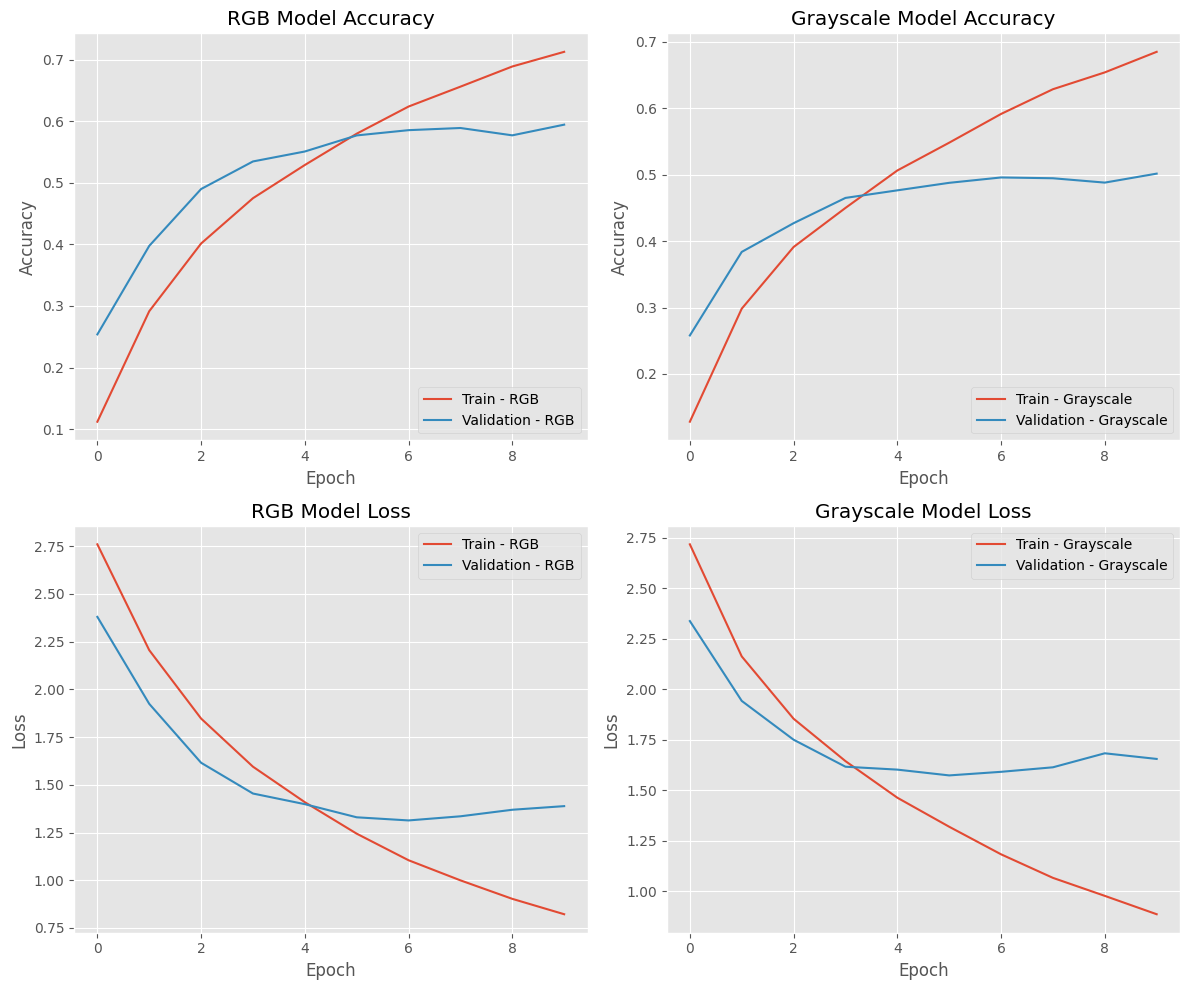

In [8]:
plt.figure(figsize=(12, 10))

# Plot RGB model accuracy
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
plt.plot(history_rgb.history['accuracy'], label='Train - RGB')
plt.plot(history_rgb.history['val_accuracy'], label='Validation - RGB')
plt.title('RGB Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot Grayscale model accuracy
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
plt.plot(history_gray.history['accuracy'], label='Train - Grayscale')
plt.plot(history_gray.history['val_accuracy'], label='Validation - Grayscale')
plt.title('Grayscale Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot RGB model loss
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 3rd subplot
plt.plot(history_rgb.history['loss'], label='Train - RGB')
plt.plot(history_rgb.history['val_loss'], label='Validation - RGB')
plt.title('RGB Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot Grayscale model loss
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 4th subplot
plt.plot(history_gray.history['loss'], label='Train - Grayscale')
plt.plot(history_gray.history['val_loss'], label='Validation - Grayscale')
plt.title('Grayscale Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

<h2>Unseen Testing</h2>

In [9]:
def create_test_generator(target_size=(128, 128), batch_size=32, color_mode='rgb'):
    """
    Create an ImageDataGenerator for the test data.

    Parameters:
    - target_size (tuple): Desired image size (height, width).
    - batch_size (int): Size of the batches of data.
    - color_mode (str): Color mode for loading images ('rgb' or 'grayscale').

    Returns:
    - test_generator: A DirectoryIterator for the test data.
    """
    # Directory is fixed to 'hagridset_test'
    directory = 'hagridset_test'
    
    # Create an ImageDataGenerator for the test data
    test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale, no augmentation

    # Load test data from directory
    test_generator = test_datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=False
    )
    return test_generator

test_generator_rgb = create_test_generator(color_mode='rgb')

test_generator_gray = create_test_generator(color_mode='grayscale')


Found 25189 images belonging to 18 classes.
Found 25189 images belonging to 18 classes.


<h2>Unseen Testing - RGB</h2>

In [10]:
test_loss, test_accuracy = model_rgb.evaluate(test_generator_rgb)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Measure inference time for a single batch from the test set
test_data, _ = next(test_generator_rgb)  
start_time = time.time()  # Start time
predictions = model_rgb.predict(test_data)  # Make predictions
end_time = time.time()  # End time

# Calculate total time and average time per image
total_time = end_time - start_time
average_time_per_image = total_time / len(test_data)

print(f"Total time to predict batch: {total_time:.4f} seconds")
print(f"Average time per image: {average_time_per_image:.4f} seconds")

788/788 [==============================] - 108s 138ms/step - loss: 1.3778 - accuracy: 0.5975
Test Loss: 1.3777743577957153
Test Accuracy: 0.5974830389022827
1/1 [==============================] - 0s 69ms/step
Total time to predict batch: 0.1010 seconds
Average time per image: 0.0032 seconds


In [11]:
true_labels = test_generator_rgb.classes
class_labels = list(test_generator_rgb.class_indices.keys())
steps = np.ceil(test_generator_rgb.n / test_generator_rgb.batch_size)

In [12]:
RGBpredictions = model_rgb.predict(test_generator_rgb, steps=steps)
RGBpredicted_classes = np.argmax(RGBpredictions, axis=1)

class_labels = list(test_generator_rgb.class_indices.keys())

print(classification_report(test_generator_rgb.classes, RGBpredicted_classes, target_names=class_labels))

788/788 [==============================] - 31s 39ms/step
                 precision    recall  f1-score   support

           call       0.68      0.69      0.68      1388
        dislike       0.71      0.81      0.76      1406
           fist       0.68      0.74      0.71      1377
           four       0.56      0.51      0.54      1437
           like       0.64      0.62      0.63      1365
           mute       0.81      0.78      0.79      1428
             ok       0.53      0.52      0.52      1385
            one       0.43      0.53      0.48      1413
           palm       0.76      0.53      0.63      1410
          peace       0.44      0.42      0.43      1393
 peace_inverted       0.60      0.65      0.62      1376
           rock       0.50      0.51      0.50      1377
           stop       0.64      0.55      0.59      1379
  stop_inverted       0.61      0.73      0.67      1429
          three       0.46      0.33      0.38      1388
         three2       0.63    

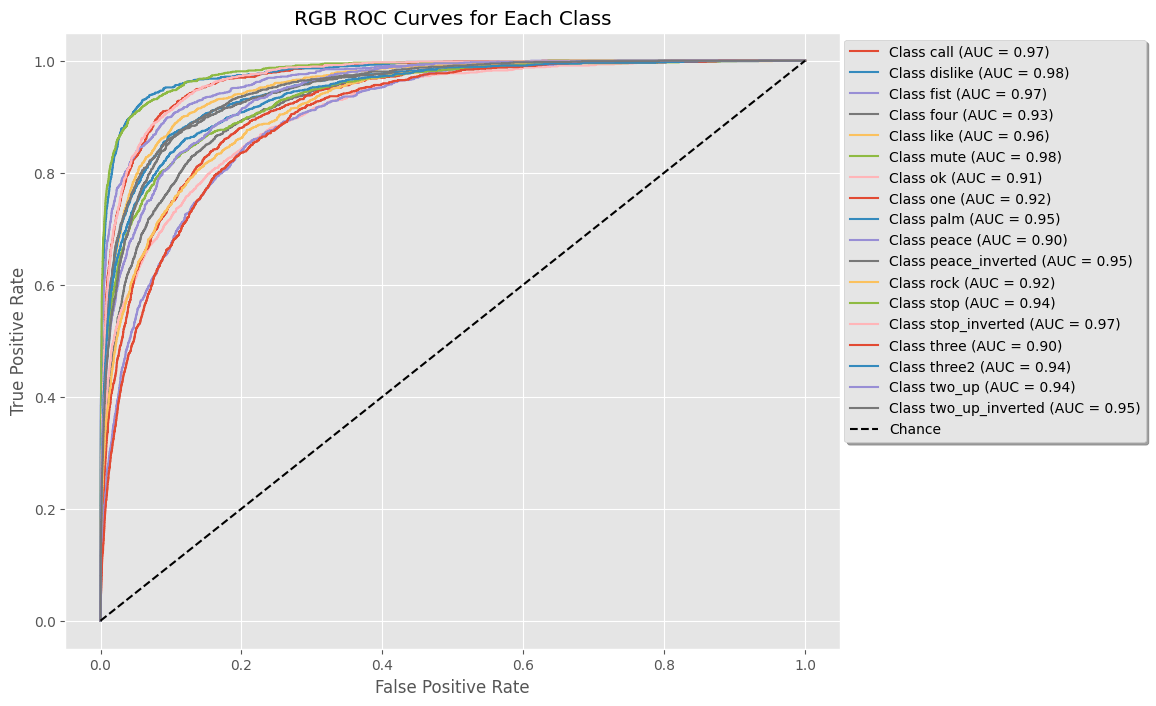

In [13]:
y = label_binarize(true_labels, classes=np.arange(len(class_labels)))
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], RGBpredictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RGB ROC Curves for Each Class')
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), fancybox=True, shadow=True, ncol=1)
plt.show()


788/788 [==============================] - 31s 39ms/step


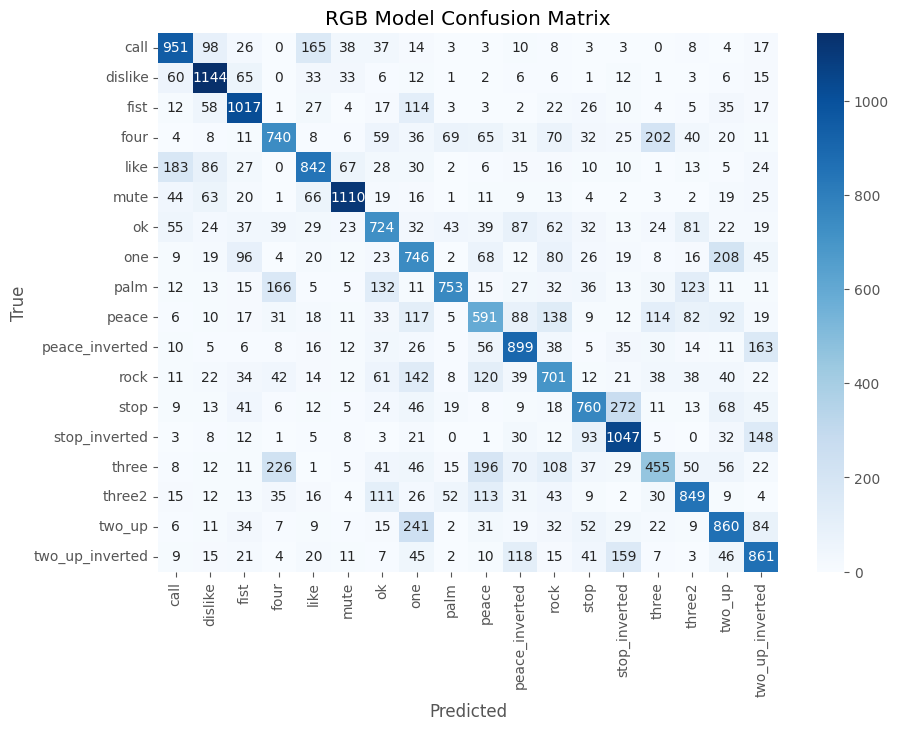

In [14]:
# Perform predictions
predictions = model_rgb.predict(test_generator_rgb, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RGB Model Confusion Matrix')
plt.show()

<h2>Visualizing Convolutional Layer Activations</h2>

1/1 [==============================] - 0s 127ms/step


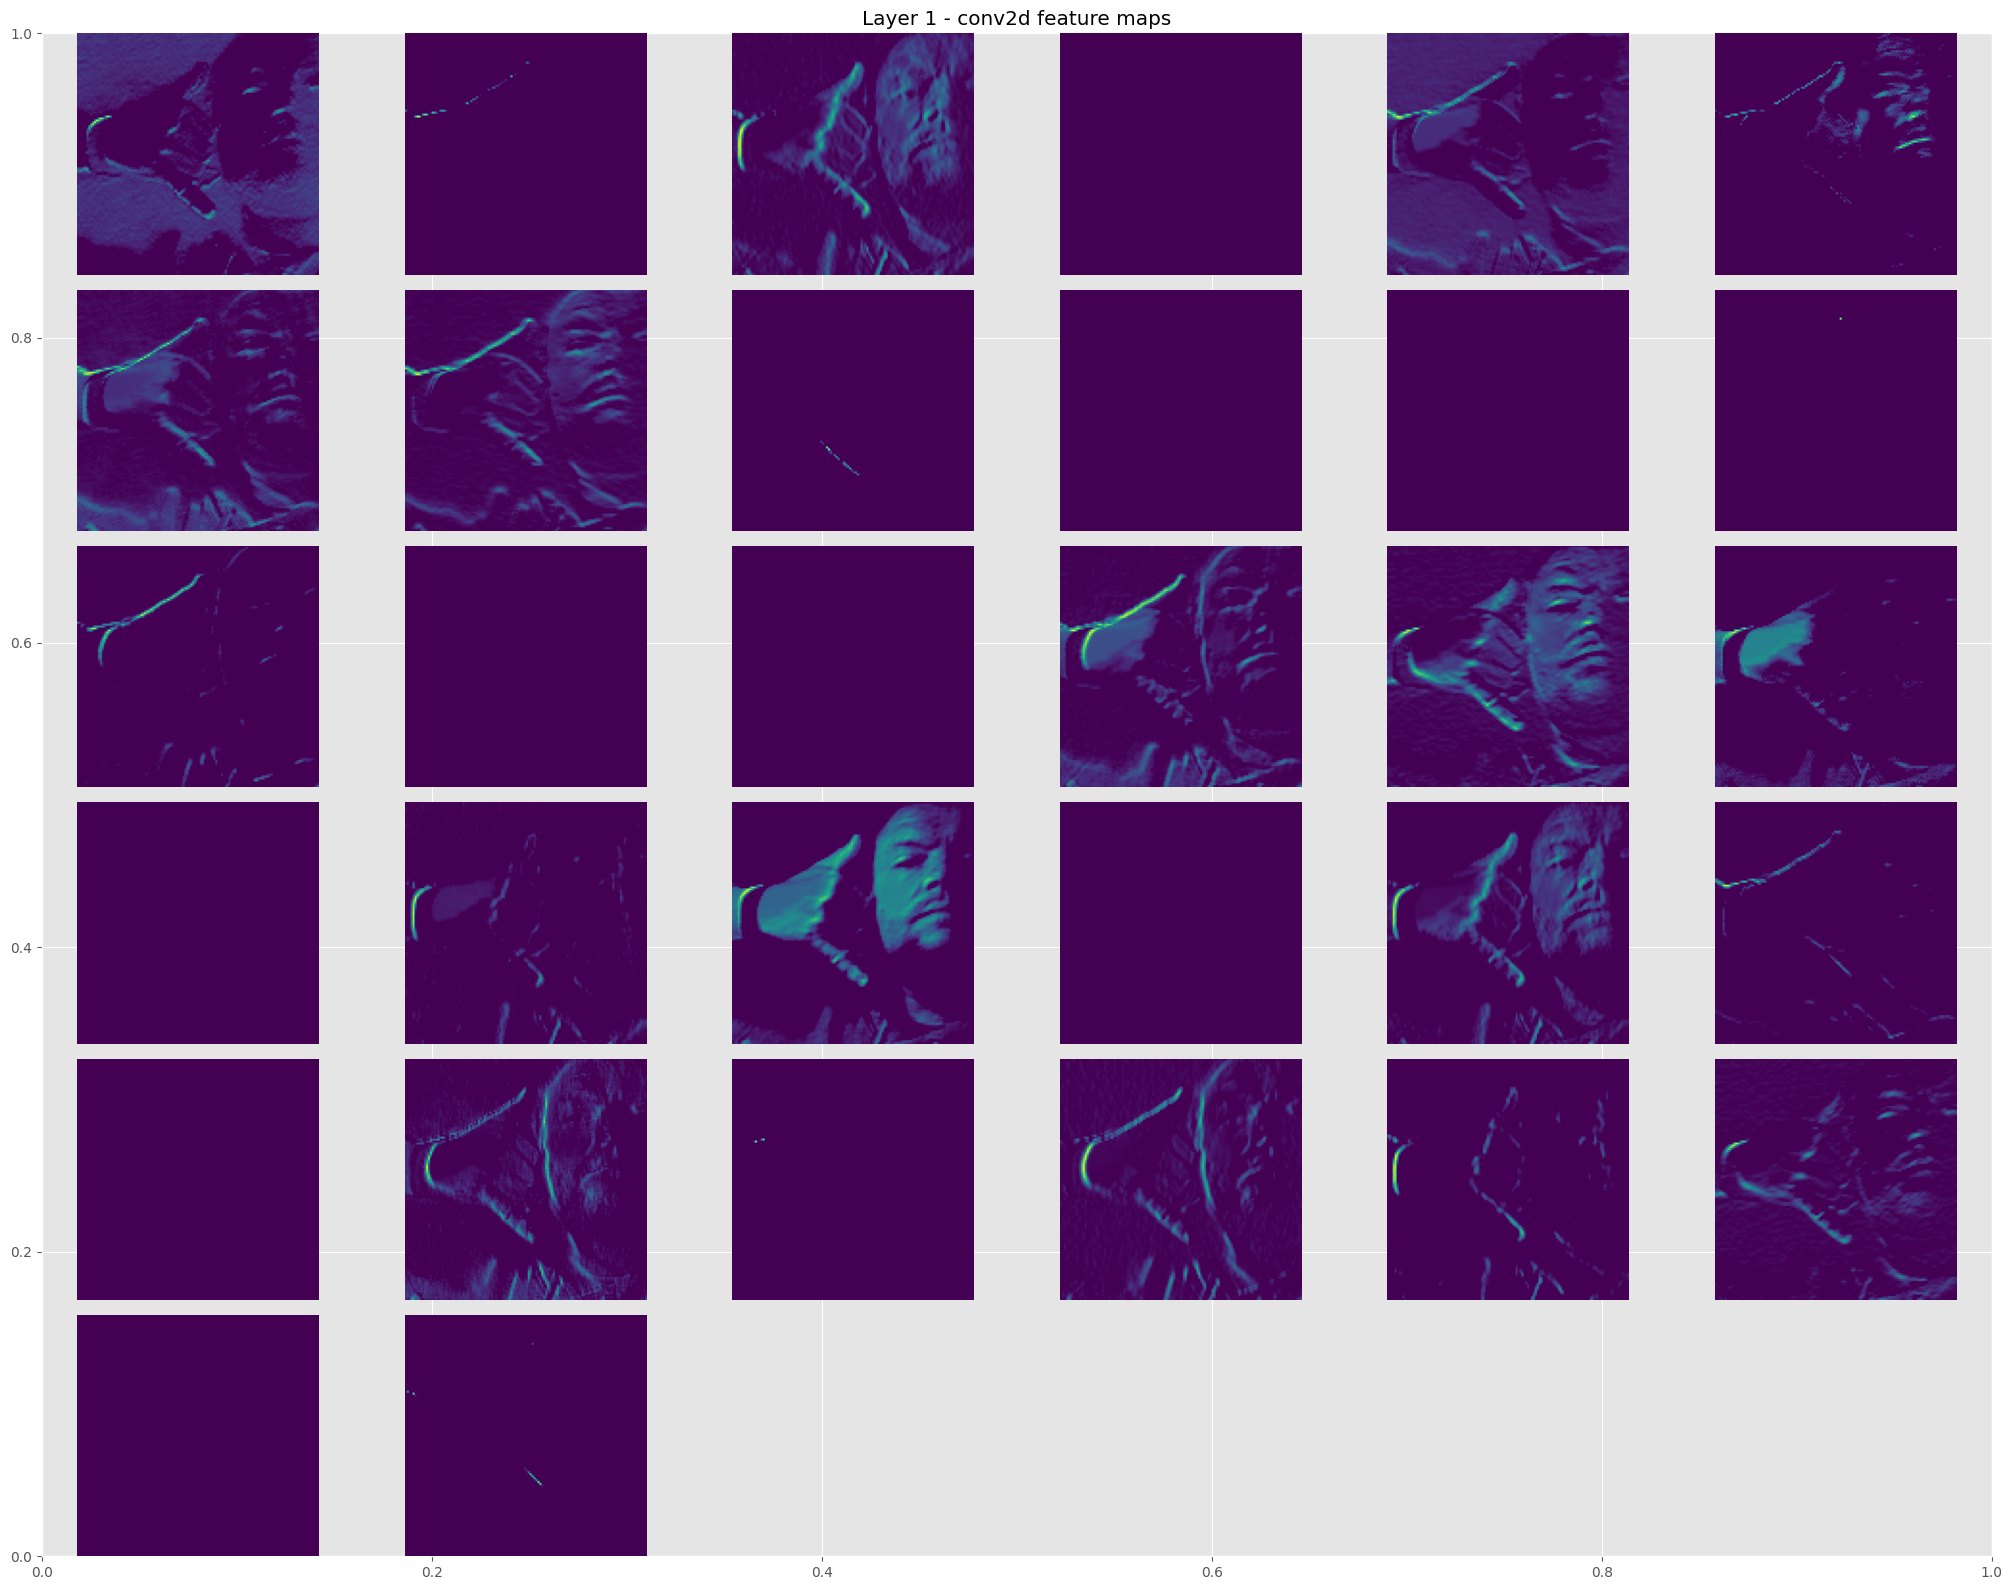

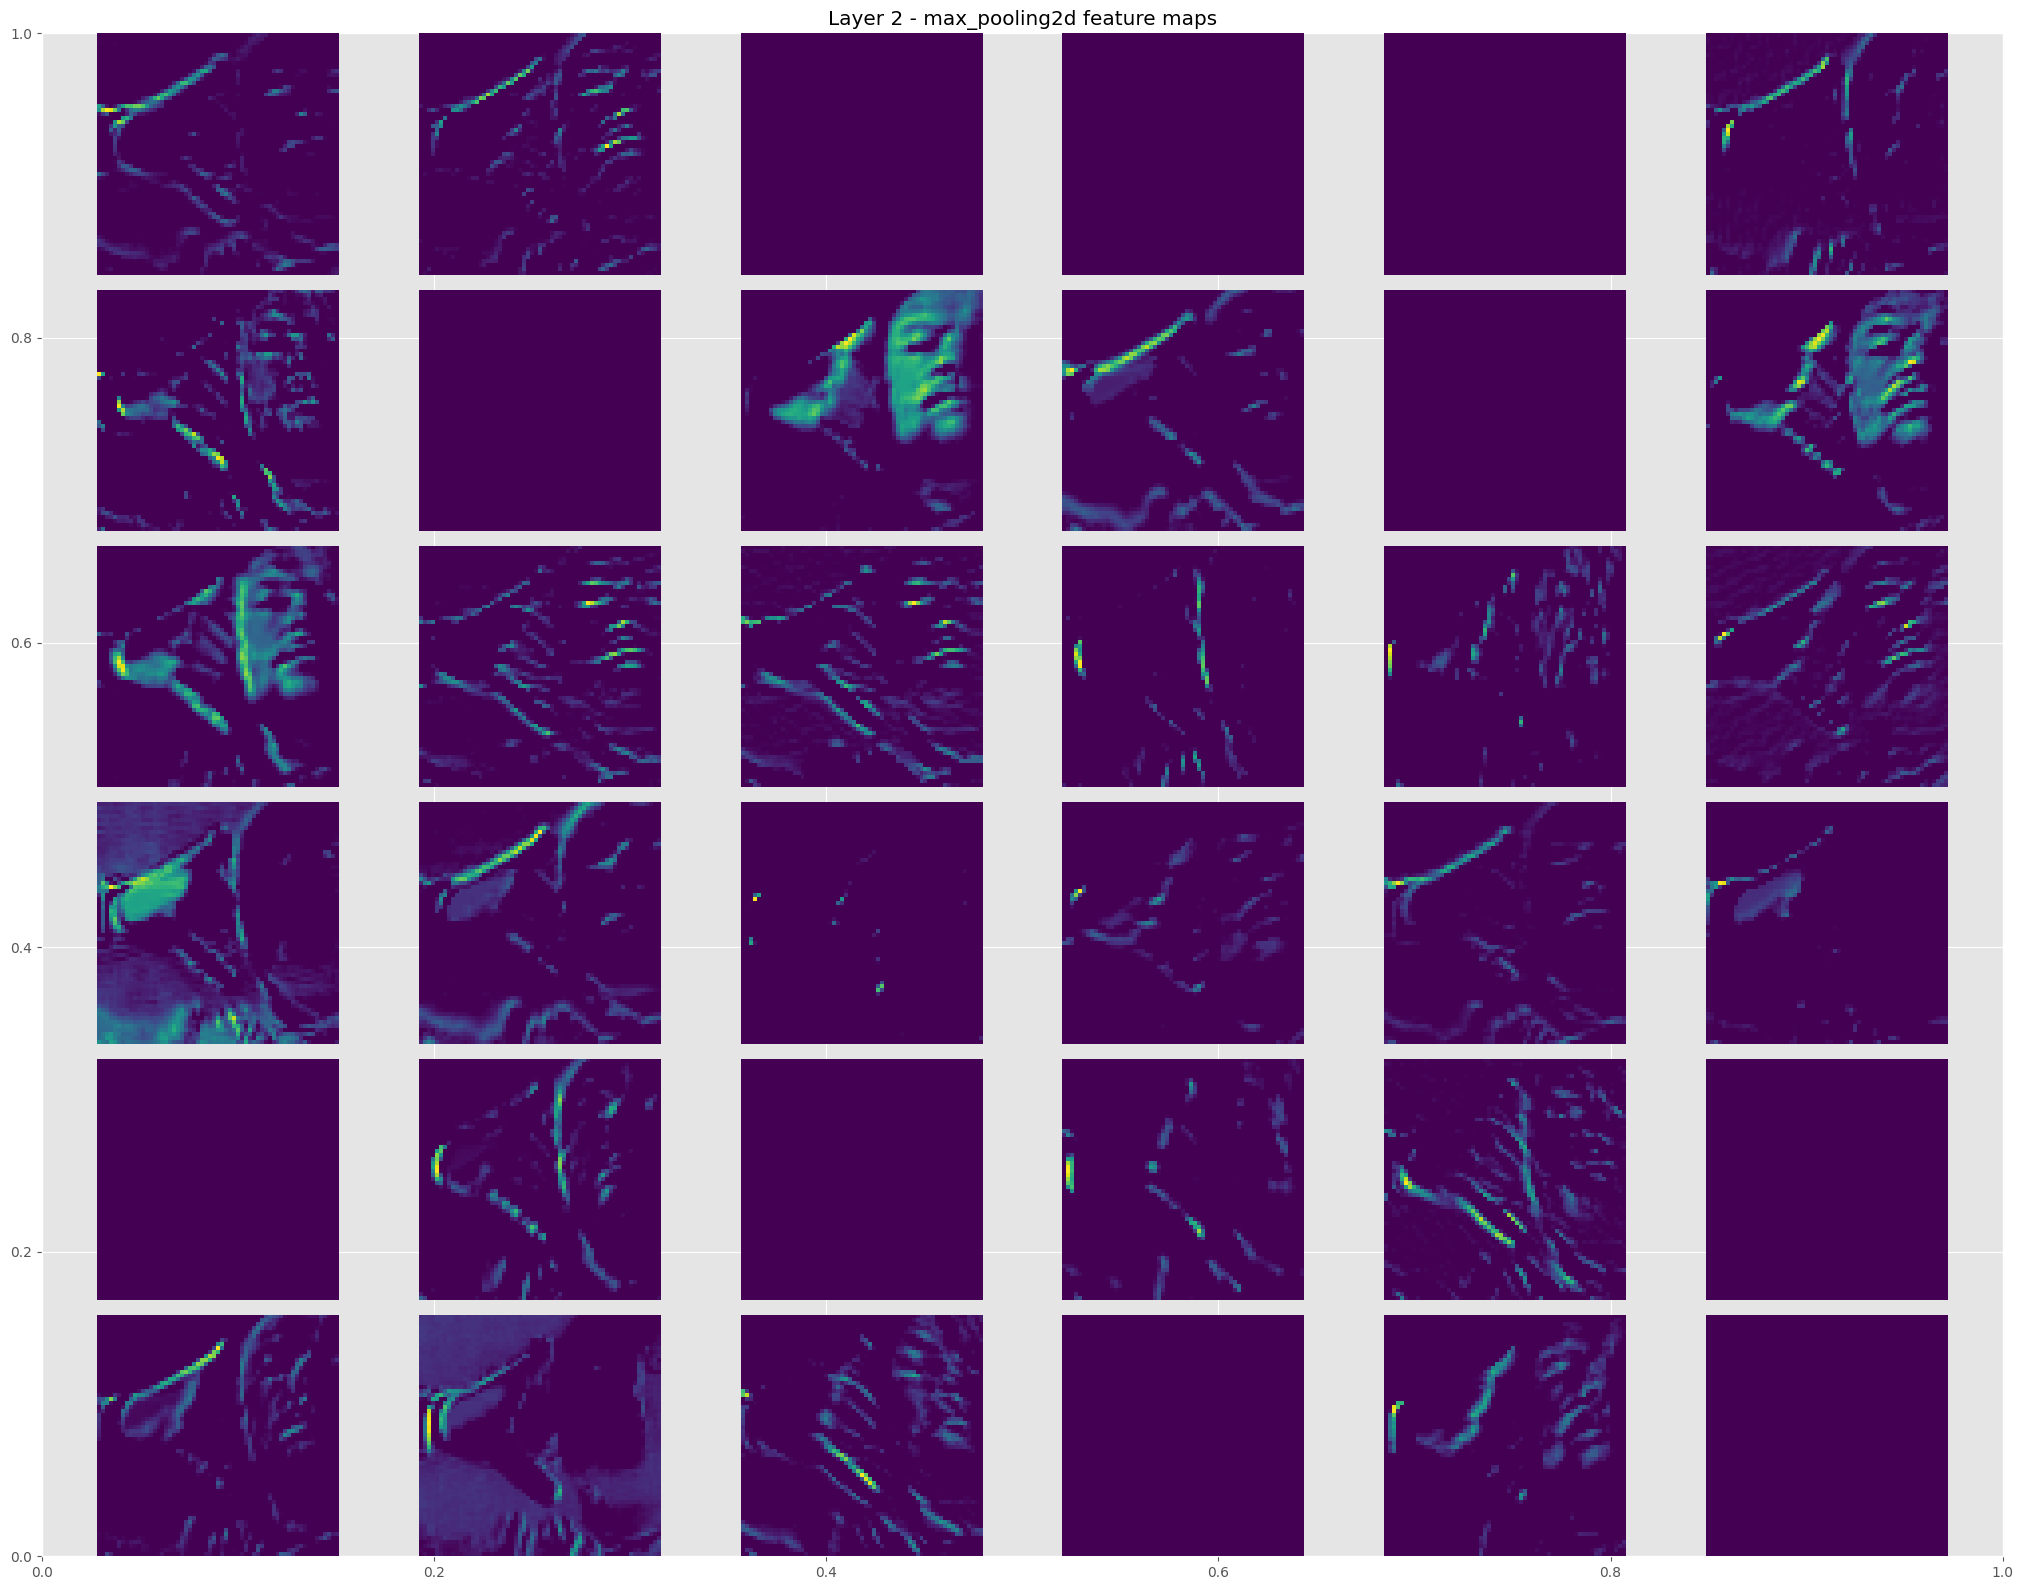

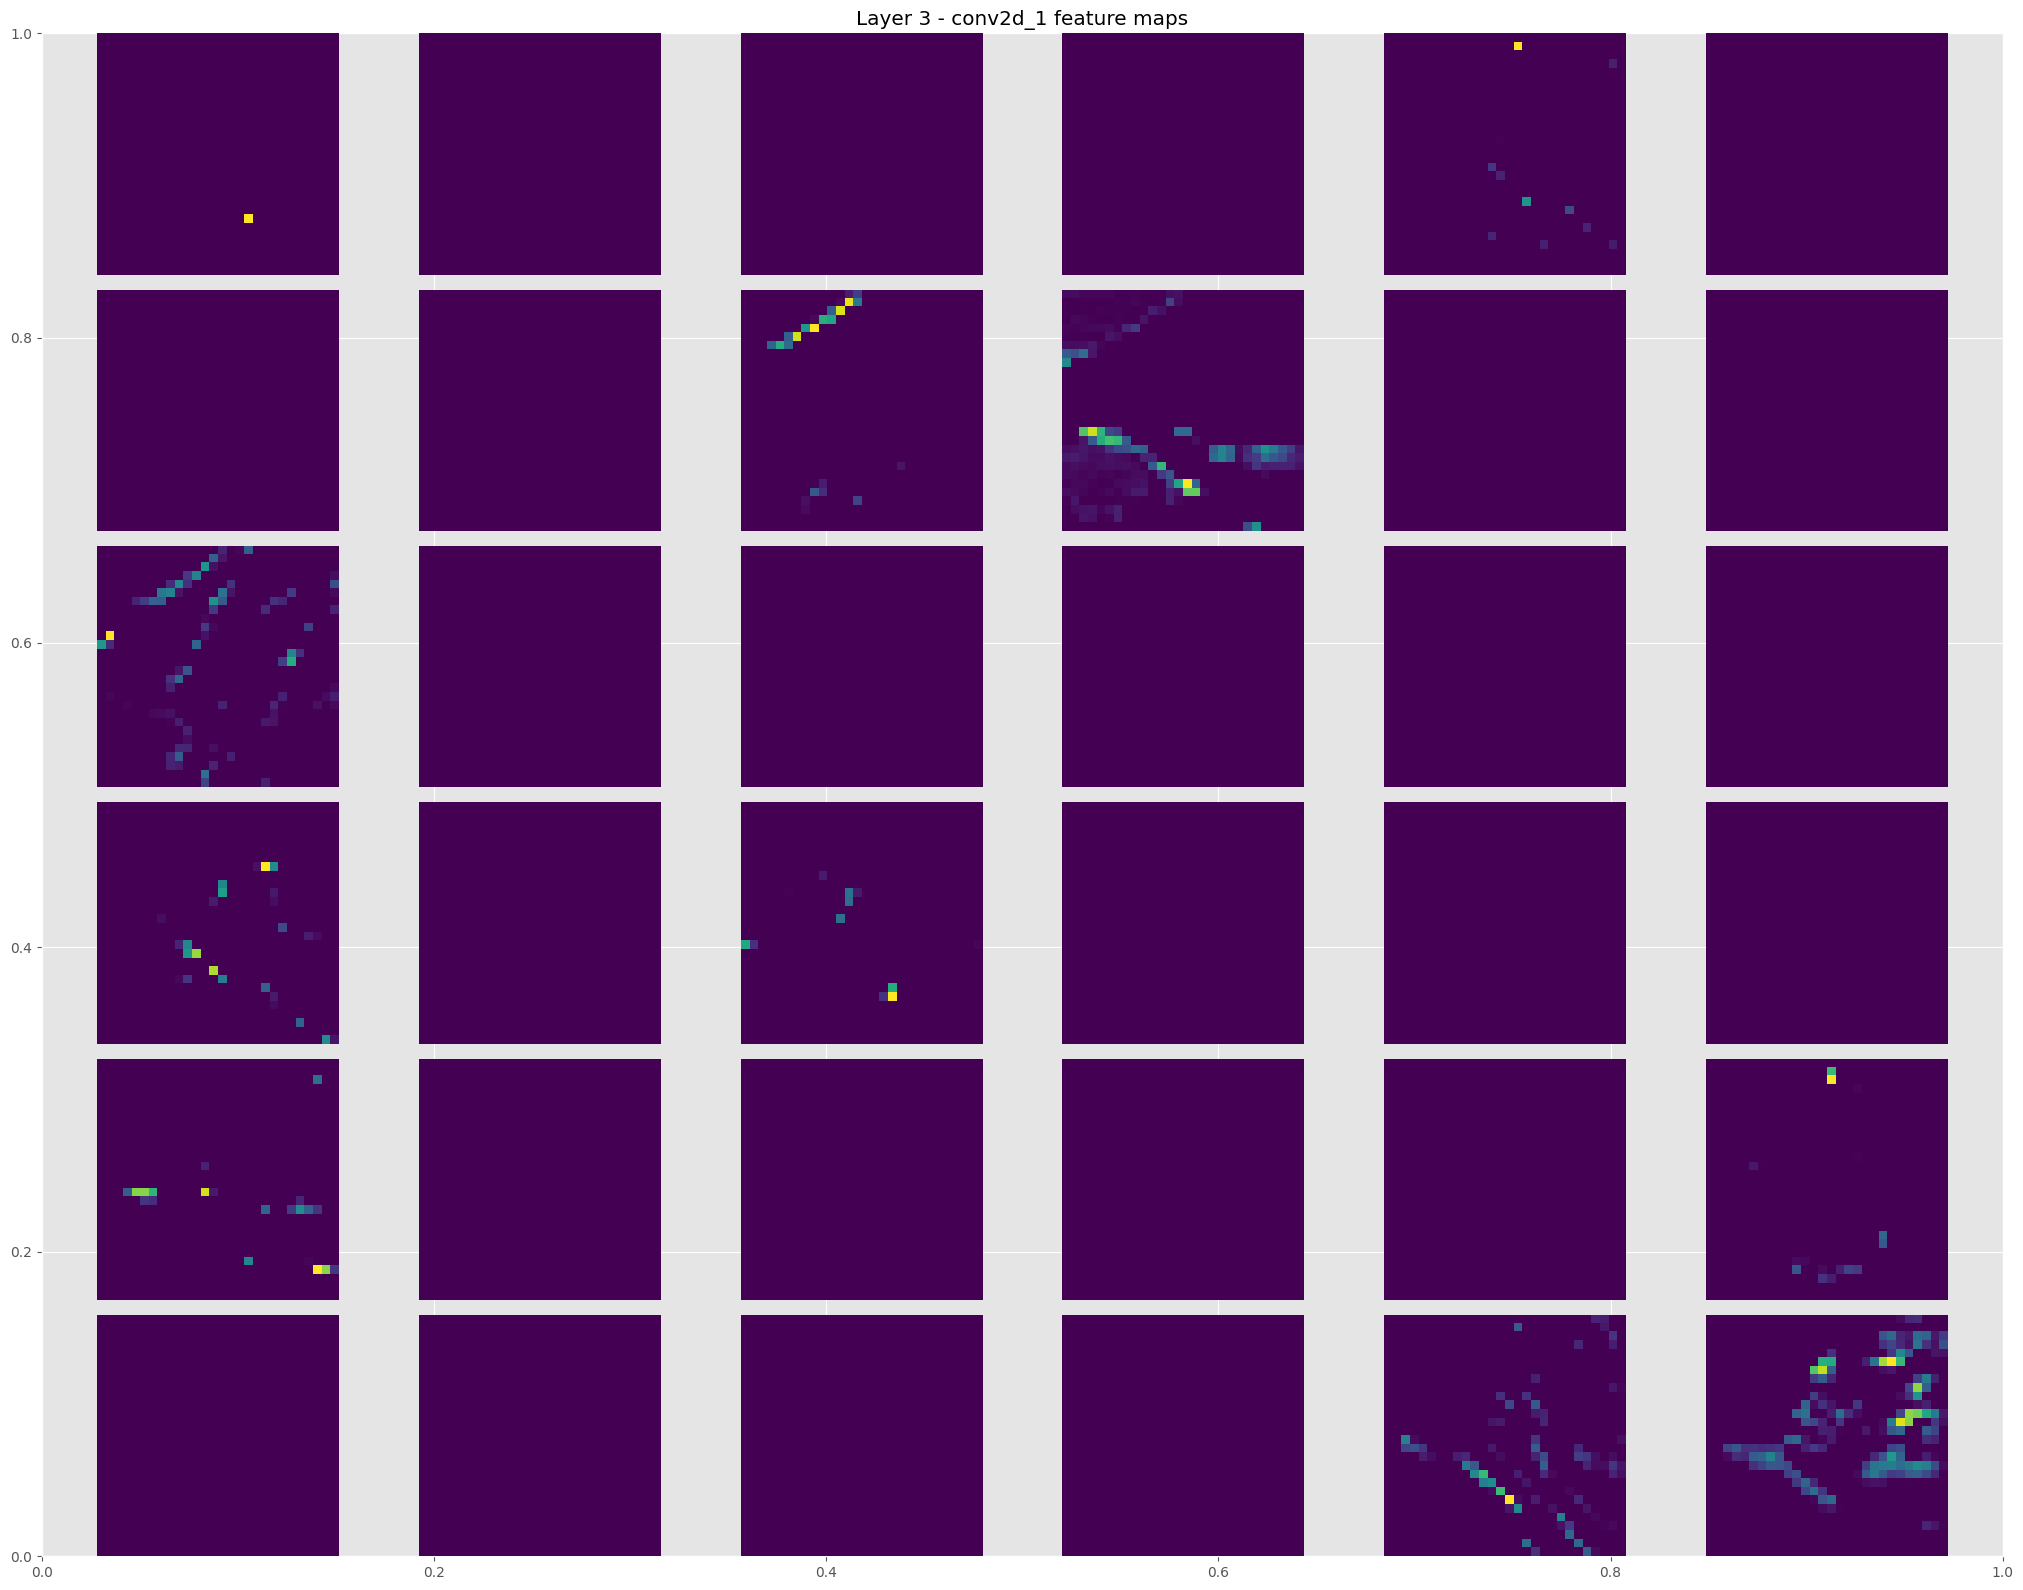

In [15]:
test_data, _ = test_generator_rgb.next()

layer_outputs = [layer.output for layer in model_rgb.layers if 'conv' in layer.name]  # Grabbing output of layers that are convolutional
activation_model = Model(inputs=model_rgb.input, outputs=layer_outputs)  # Creates a model that will return these outputs, given the model input

activations = activation_model.predict(np.expand_dims(test_data[0], axis=0))

# Plotting feature maps
for i, activation in enumerate(activations):
    num_filters = activation.shape[-1]  # Number of filters in the output of the current layer
    num_features_show = min(num_filters, 36)  # Decide to show only up to 36 features for simplicity

    grid_size = int(np.ceil(np.sqrt(num_features_show)))

    plt.figure(figsize=(20, 16))
    plt.title(f'Layer {i + 1} - {model_rgb.layers[i].name} feature maps')

    for j in range(num_features_show):
        ax = plt.subplot(grid_size, grid_size, j + 1)
        plt.imshow(activation[0, :, :, j], cmap='viridis')
        plt.axis('off')
    
    plt.tight_layout() 
    plt.show()


<h2>Unseen Testing - Grayscale</h2>

In [16]:
model_gray = load_model('models/model_gray.h5')

test_generator_gray = create_test_generator(color_mode='grayscale')

steps = np.ceil(test_generator_gray.samples / test_generator_gray.batch_size)

GRAYpredictions = model_gray.predict(test_generator_gray, steps=steps)
GRAYpredicted_classes = np.argmax(GRAYpredictions, axis=1)

class_labels_gray = list(test_generator_gray.class_indices.keys())

print(classification_report(test_generator_gray.classes, GRAYpredicted_classes, target_names=class_labels_gray))


Found 25189 images belonging to 18 classes.
788/788 [==============================] - 34s 43ms/step
                 precision    recall  f1-score   support

           call       0.64      0.63      0.63      1388
        dislike       0.70      0.73      0.71      1406
           fist       0.65      0.62      0.64      1377
           four       0.44      0.44      0.44      1437
           like       0.56      0.56      0.56      1365
           mute       0.74      0.77      0.75      1428
             ok       0.44      0.44      0.44      1385
            one       0.38      0.29      0.33      1413
           palm       0.58      0.54      0.56      1410
          peace       0.30      0.32      0.31      1393
 peace_inverted       0.57      0.56      0.56      1376
           rock       0.42      0.42      0.42      1377
           stop       0.44      0.44      0.44      1379
  stop_inverted       0.52      0.62      0.57      1429
          three       0.35      0.33      0

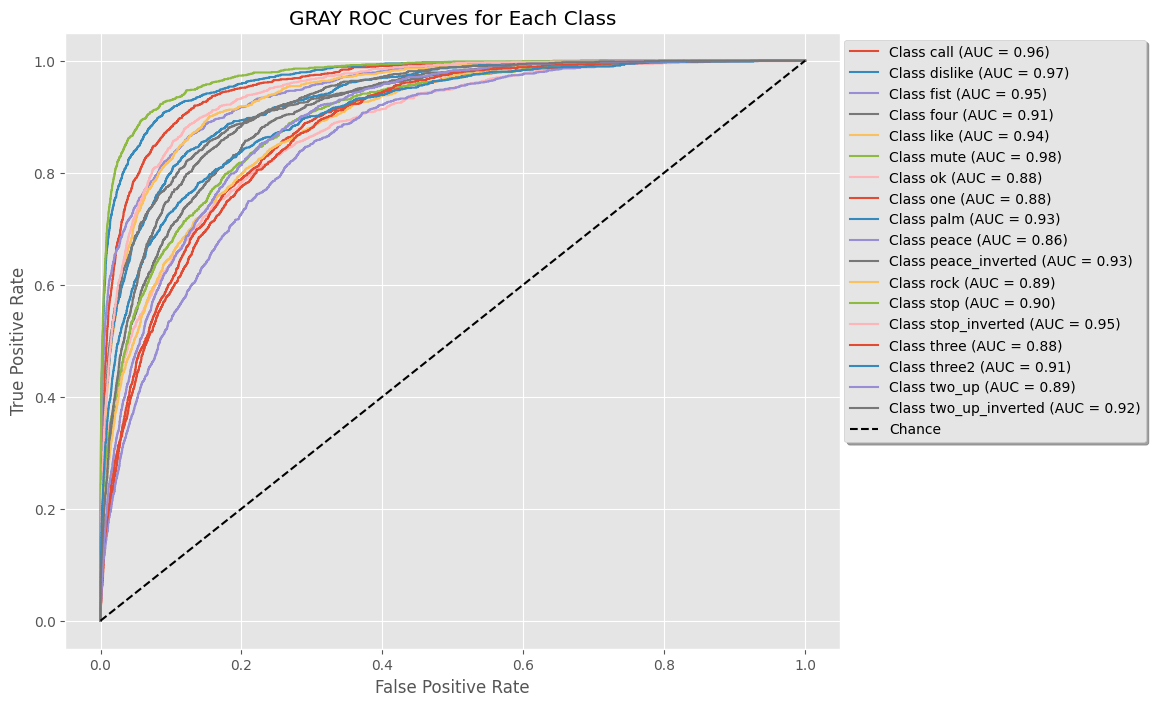

In [17]:
y = label_binarize(true_labels, classes=np.arange(len(class_labels)))
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], GRAYpredictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GRAY ROC Curves for Each Class')
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), fancybox=True, shadow=True, ncol=1)
plt.show()


788/788 [==============================] - 35s 44ms/step


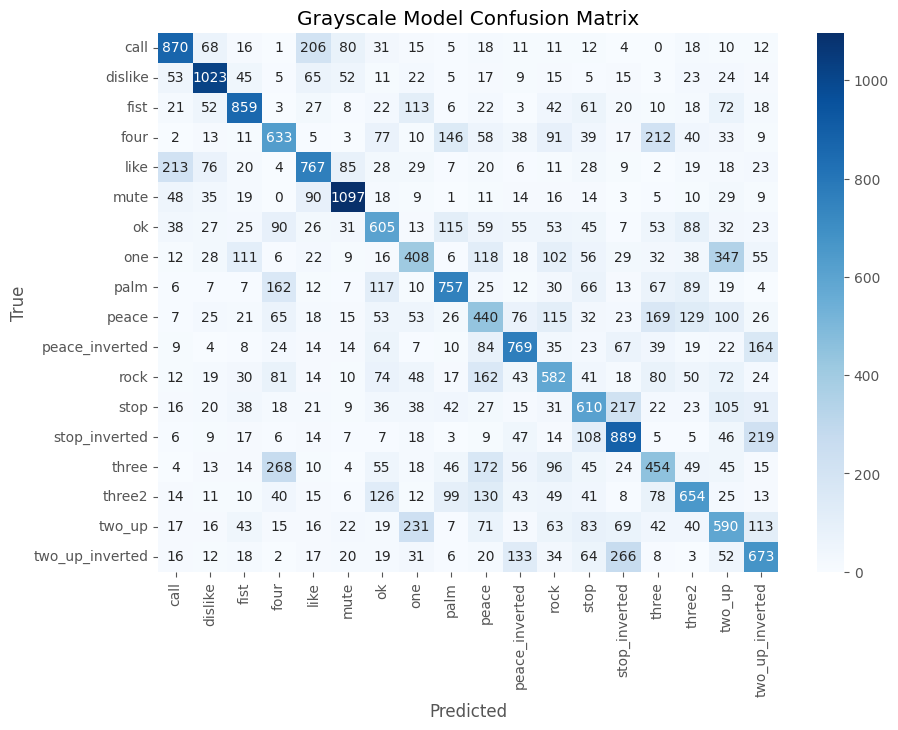

In [18]:
steps = np.ceil(test_generator_gray.samples / test_generator_gray.batch_size)
GRAYpredictions = model_gray.predict(test_generator_gray, steps=steps)
GRAYpredicted_classes = np.argmax(GRAYpredictions, axis=1)

# Extract true labels correctly
true_classes = test_generator_gray.classes

# Compute confusion matrix
cm_gray = confusion_matrix(true_classes, GRAYpredicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_gray, annot=True, fmt='d', cmap='Blues', xticklabels=val_gen_gray.class_indices, yticklabels=val_gen_gray.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Grayscale Model Confusion Matrix')
plt.show()

<h2>Transfer Learning</h2>

In [19]:
def build_transfer_model(input_shape, num_classes, fc_units=128, dropout_rate=0.5, freeze_base=True):

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    

    if freeze_base:
        base_model.trainable = False
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(fc_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [20]:
# Compile the VGG-16 model
input_shape = (128, 128, 3)  
num_classes = len(train_gen_rgb.class_indices) 
model_vgg16 = build_transfer_model(input_shape, num_classes)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [21]:
start_time = time.time()

history_vgg16 = model_vgg16.fit(
    train_gen_rgb,
    epochs=10,
    validation_data=val_gen_rgb
)

# Save the grayscale model
model_gray.save('models/model_vgg16.h5')

end_time = time.time()
training_duration = end_time - start_time
print(f"Training completed in {training_duration:.2f} seconds")

Epoch 1/10
1102/1102 [==============================] - 66s 59ms/step - loss: 2.5332 - accuracy: 0.1481 - val_loss: 2.1245 - val_accuracy: 0.3239
Epoch 2/10
1102/1102 [==============================] - 63s 57ms/step - loss: 2.3412 - accuracy: 0.1887 - val_loss: 1.9957 - val_accuracy: 0.3439
Epoch 3/10
1102/1102 [==============================] - 64s 58ms/step - loss: 2.2927 - accuracy: 0.1991 - val_loss: 1.9153 - val_accuracy: 0.3861
Epoch 4/10
1102/1102 [==============================] - 63s 58ms/step - loss: 2.2520 - accuracy: 0.2093 - val_loss: 1.9349 - val_accuracy: 0.3728
Epoch 5/10
1102/1102 [==============================] - 63s 57ms/step - loss: 2.2346 - accuracy: 0.2149 - val_loss: 1.7969 - val_accuracy: 0.4186
Epoch 6/10
1102/1102 [==============================] - 63s 58ms/step - loss: 2.2156 - accuracy: 0.2182 - val_loss: 1.8017 - val_accuracy: 0.4200
Epoch 7/10
1102/1102 [==============================] - 63s 57ms/step - loss: 2.2015 - accuracy: 0.2207 - val_loss: 1.7856 -

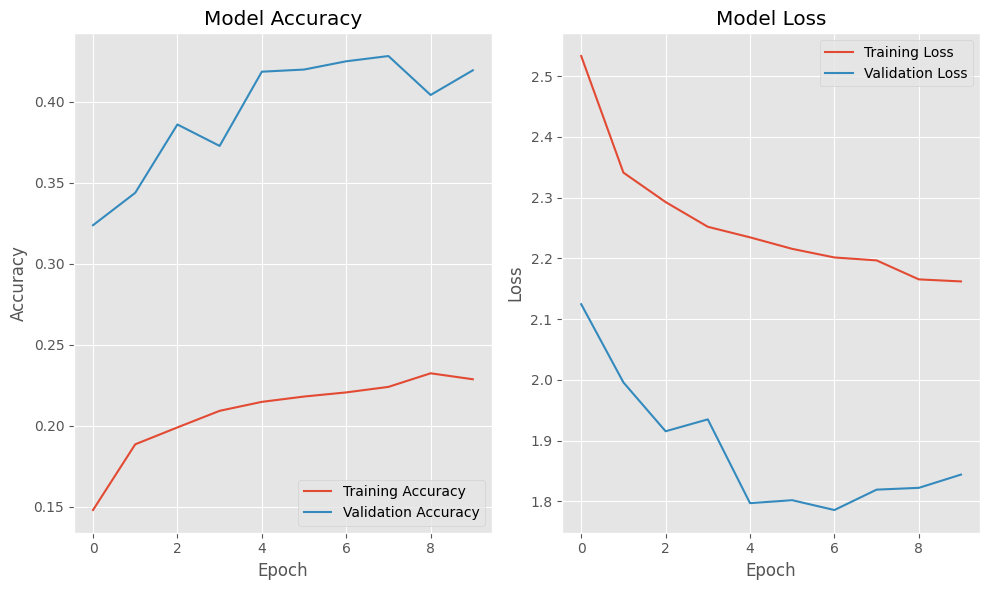

In [22]:
train_loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
train_acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']


plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)  
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)  
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  
plt.show()


<h2>Testing using Images RGB, Gray, VGG16</h2>

<h3>RGB using my Images</h3>

In [23]:
def correct_orientation(img_path):
    img = Image.open(img_path)
    if hasattr(img, '_getexif'):
        exif = img._getexif()
        if exif is not None:
            orientation_tag = 274
            orientation = exif.get(orientation_tag, 1)
            orientation_dict = {3: 180, 6: 270, 8: 90}
            img = img.rotate(orientation_dict.get(orientation, 0), expand=True)
    return img

1/1 [==============================] - 0s 48ms/step
RGB Model predictions with my images:


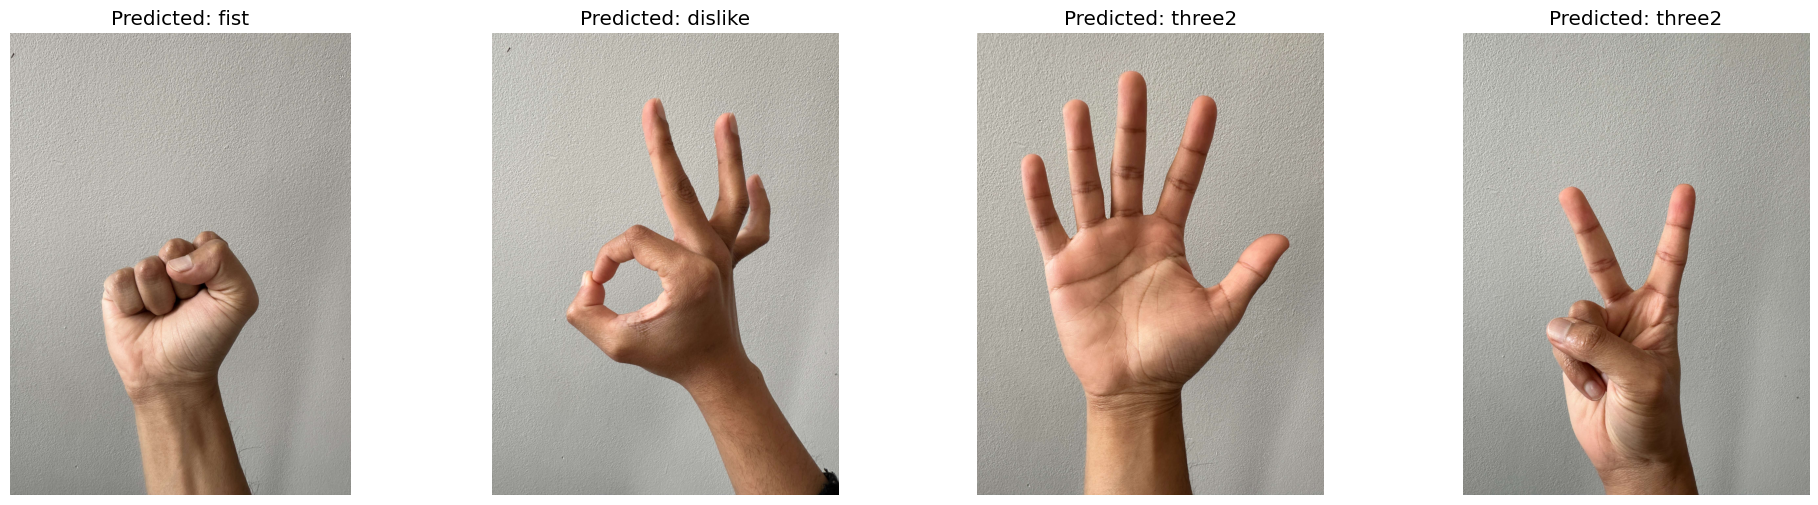

In [25]:
model_rgb = load_model('models/model_rgb.h5')
image_folder = 'myimages'
image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
target_size = (128, 128)

images = []
file_names = []

# Process each image
for file in image_files:
    img = Image.open(file) 
    img = img.resize(target_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    images.append(img_array)
    file_names.append(os.path.basename(file))

images = np.array(images)
predictions = model_rgb.predict(images)
predicted_indices = np.argmax(predictions, axis=1)

index_to_class = {v: k for k, v in test_generator_rgb.class_indices.items()}
predicted_labels = [index_to_class[idx] for idx in predicted_indices]

print("RGB Model predictions with my images:")
# Display images horizontally
plt.figure(figsize=(len(image_files) * 6, 6)) 
for i, img_path in enumerate(image_files):
    img = Image.open(img_path)
    ax = plt.subplot(1, len(image_files), i + 1) 
    ax.imshow(img)
    ax.set_title(f"Predicted: {predicted_labels[i]}")
    ax.axis('off')
plt.show()

<h3>Grayscale using my Images</h3>

1/1 [==============================] - 0s 143ms/step
Grayscale Model predictions with my images:


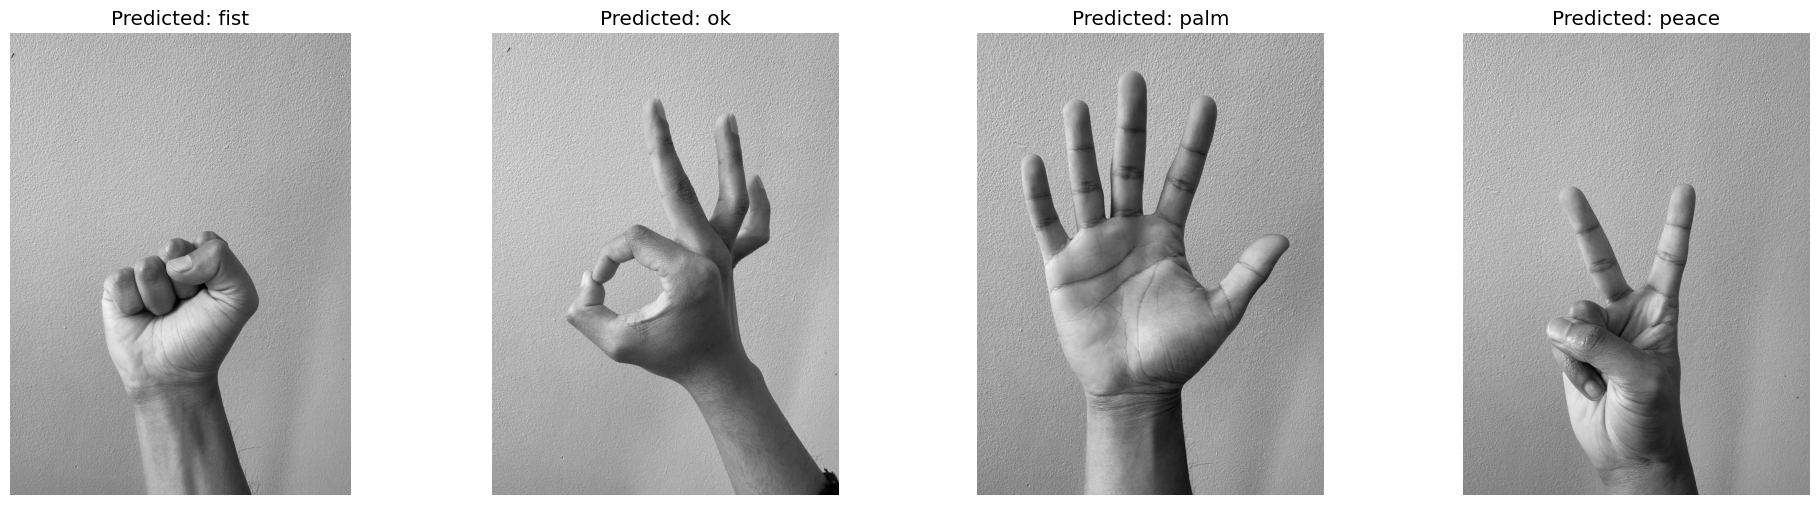

In [26]:
def preprocess_grayscale(img_array):
    return img_array / 255.0

model_gray = load_model('models/model_gray.h5')
image_folder = 'myimages'
image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
target_size = (128, 128)

images = []

for file in image_files:
    img = correct_orientation(file)
    img = img.resize(target_size)
    img = img.convert('L')  # Convert to grayscale
    img_array = img_to_array(img)
    img_array = preprocess_grayscale(img_array) 
    images.append(img_array)

images = np.array(images)
predictions = model_gray.predict(images)
predicted_indices = np.argmax(predictions, axis=1)

index_to_class = {v: k for k, v in test_generator_gray.class_indices.items()}
predicted_labels = [index_to_class[idx] for idx in predicted_indices]

print("Grayscale Model predictions with my images:")
plt.figure(figsize=(len(image_files) * 6, 6)) 
for i, img_path in enumerate(image_files):
    img = Image.open(img_path)
    img = img.convert('L')
    ax = plt.subplot(1, len(image_files), i + 1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Predicted: {predicted_labels[i]}")
    ax.axis('off')
plt.show()